In [1]:
# Data Collection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pandas Profiling
from ydata_profiling import ProfileReport

# Scikit-Learn Libraries
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# SciPy for Statistics
from scipy.stats import multivariate_normal

# Matplotlib and visualization tools
%matplotlib inline

In [2]:
# Load the dataset
data = pd.read_csv("stocks.csv")

In [3]:
# Display basic info
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     248 non-null    object 
 1   Date       248 non-null    object 
 2   Open       248 non-null    float64
 3   High       248 non-null    float64
 4   Low        248 non-null    float64
 5   Close      248 non-null    float64
 6   Adj Close  248 non-null    float64
 7   Volume     248 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.6+ KB
None


In [4]:
print(data.head(10))

  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   
5   AAPL  2023-02-14  152.119995  153.770004  150.860001  153.199997   
6   AAPL  2023-02-15  153.110001  155.500000  152.880005  155.330002   
7   AAPL  2023-02-16  153.509995  156.330002  153.350006  153.710007   
8   AAPL  2023-02-17  152.350006  153.000000  150.850006  152.550003   
9   AAPL  2023-02-21  150.199997  151.300003  148.410004  148.479996   

    Adj Close    Volume  
0  154.414230  83322600  
1  151.688400  64120100  
2  150.639999  56007100  
3  151.009995  57450700  
4  153.850006  62199000  
5  153.199997  61707600  
6  155.330002  65573800  

In [5]:
print("Unique Tickers:\n", data['Ticker'].unique())

Unique Tickers:
 ['AAPL' 'MSFT' 'NFLX' 'GOOG']


In [6]:
print("Data Summary:\n")
print(data.describe())

Data Summary:

             Open        High         Low       Close   Adj Close  \
count  248.000000  248.000000  248.000000  248.000000  248.000000   
mean   215.252093  217.919662  212.697452  215.381674  215.362697   
std     91.691315   92.863023   90.147881   91.461989   91.454750   
min     89.540001   90.129997   88.860001   89.349998   89.349998   
25%    135.235004  137.440004  134.822495  136.347498  136.347498   
50%    208.764999  212.614998  208.184998  209.920006  209.920006   
75%    304.177505  307.565002  295.437500  303.942505  303.942505   
max    372.410004  373.829987  361.739990  366.829987  366.829987   

             Volume  
count  2.480000e+02  
mean   3.208210e+07  
std    2.233590e+07  
min    2.657900e+06  
25%    1.714180e+07  
50%    2.734000e+07  
75%    4.771772e+07  
max    1.133164e+08  


In [7]:
print("Data Shape:\n", data.shape)

Data Shape:
 (248, 8)


In [8]:
print("Data Types:\n", data.dtypes)

Data Types:
 Ticker        object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [9]:
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [10]:
# Data Preprocessing
data['Date'] = pd.to_datetime(data['Date'])

label_encoder = LabelEncoder()
data['Ticker'] = label_encoder.fit_transform(data['Ticker'])

data.fillna(data.mean(), inplace=True)

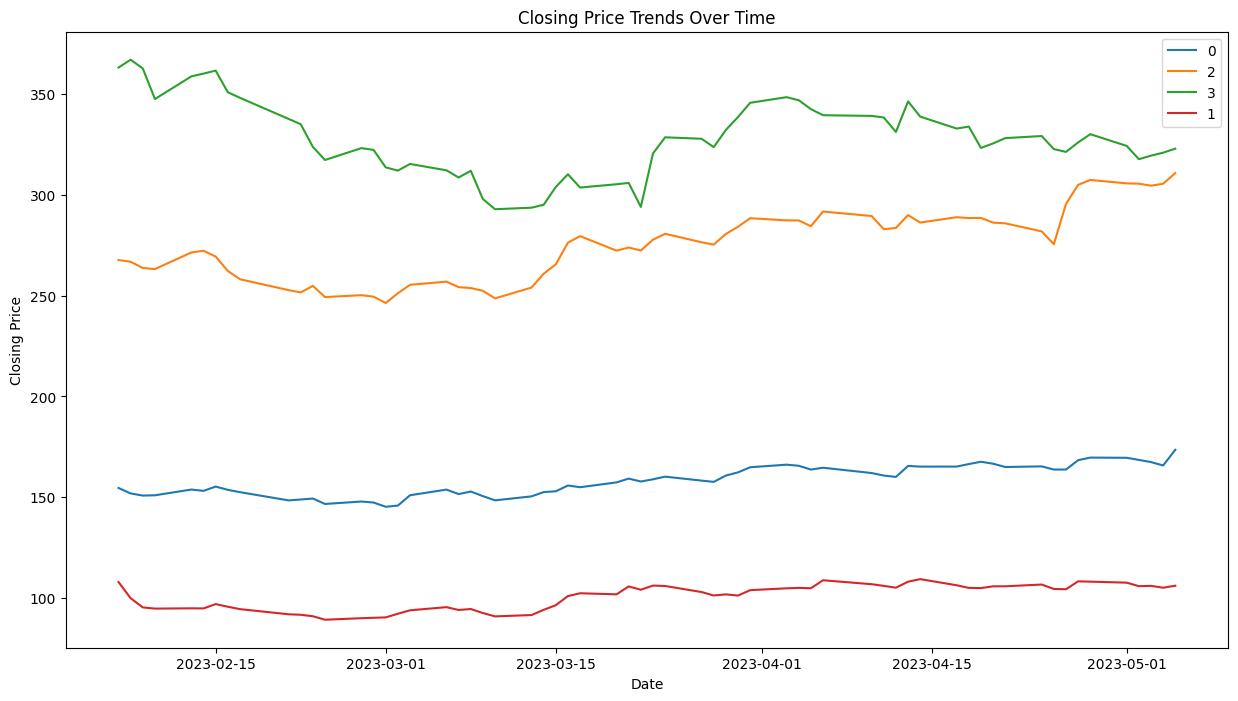

In [11]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(15, 8))
for ticker in data['Ticker'].unique():
    ticker_data = data[data['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Close'], label=ticker)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Trends Over Time')
plt.legend()
plt.show()

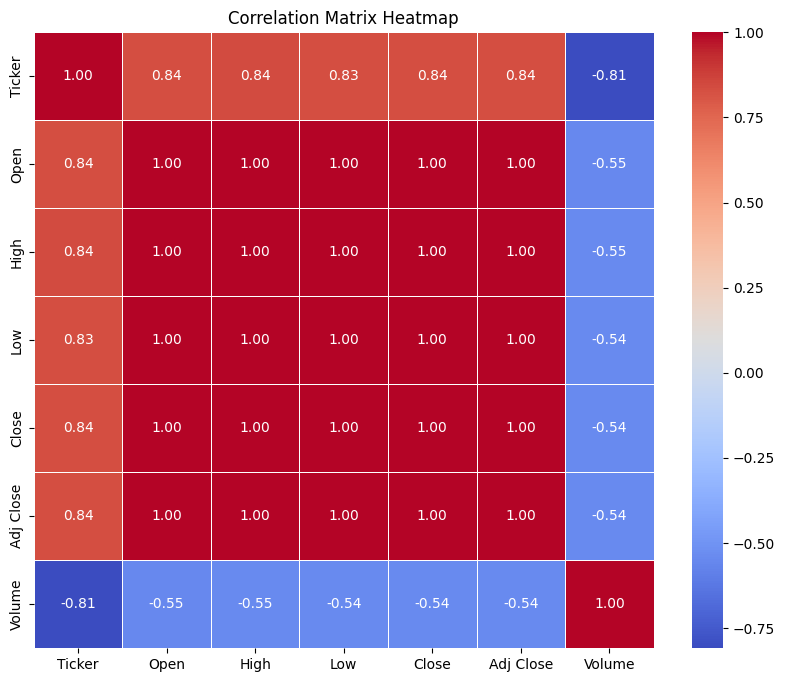

In [12]:
# Correlation Matrix
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

In [13]:
# Feature Engineering
data['10_MA'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
data['20_MA'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
data['Daily_Return'] = data.groupby('Ticker')['Close'].pct_change()
data['Volatility'] = data.groupby('Ticker')['Daily_Return'].transform(lambda x: x.rolling(window=10, min_periods=1).std())

data[['10_MA', '20_MA', 'Volatility']] = data[['10_MA', '20_MA', 'Volatility']].fillna(0)

In [14]:
# Pandas Profiling
profile = ProfileReport(data, title="Stock Market Analysis")
profile.to_file("index.html")
print("Pandas Profiling report saved as 'index.html'.")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<?, ?it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Profiling report saved as 'index.html'.


In [15]:
# Data Storage (Excel & SQL)
data.to_excel("stock_market_data.xlsx", index=False)
print("Data exported to Excel")

import sqlite3
conn = sqlite3.connect("stocks.db")
data.to_sql("stock_data", conn, if_exists="replace", index=False)
conn.close()
print("Data saved to SQL database")

Data exported to Excel
Data saved to SQL database


In [16]:
# Feature Engineering
data['50_MA'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
data['Volatility'] = data.groupby('Ticker')['Close'].transform(lambda x: x.pct_change().rolling(window=10, min_periods=1).std())
data[['50_MA', 'Volatility']] = data[['50_MA', 'Volatility']].fillna(0)
print(data[['50_MA', 'Volatility']].head())

        50_MA  Volatility
0  154.649994    0.000000
1  153.284996    0.000000
2  152.479996    0.007595
3  152.112495    0.009328
4  152.459998    0.015364


In [17]:
# Machine Learning Model Implementation
data['Ticker_Encoded'] = label_encoder.fit_transform(data['Ticker'])

X = data[['Open', 'High', 'Low', 'Volume', 'Ticker_Encoded', '10_MA', '20_MA', 'Volatility']]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

rf_model = grid_search.best_estimator_
print("Best Parameters for Random Forest:", grid_search.best_params_)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [19]:
# Train Models
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_predictions = dt_model.predict(X_test_scaled)

# Random Forest model
rf_predictions = rf_model.predict(X_test_scaled)

In [20]:
# Model Evaluation
mse_lr = mean_squared_error(y_test, lr_predictions)
r2_lr = r2_score(y_test, lr_predictions)
print("\nLinear Regression Performance:")
print("MSE:", mse_lr)
print("R² Score:", r2_lr)


Linear Regression Performance:
MSE: 2.0992285074134616
R² Score: 0.9997426926673159


In [21]:
mse_dt = mean_squared_error(y_test, dt_predictions)
r2_dt = r2_score(y_test, dt_predictions)
print("\nDecision Tree Performance:")
print("MSE:", mse_dt)
print("R² Score:", r2_dt)


Decision Tree Performance:
MSE: 8.590616505742071
R² Score: 0.9989470281051357


In [22]:
mse_rf = mean_squared_error(y_test, rf_predictions)
r2_rf = r2_score(y_test, rf_predictions)
print("\nOptimized Random Forest Performance:")
print("MSE:", mse_rf)
print("R² Score:", r2_rf)


Optimized Random Forest Performance:
MSE: 5.303149564868461
R² Score: 0.9993499805930883


In [23]:
# Save Model and Preprocessing Objects
import joblib
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Optimized Model, Scaler, and Label Encoder saved!")

Optimized Model, Scaler, and Label Encoder saved!
